## 데이터 내려받기 테스트

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ssangmg","key":"2ee25bb905ec9f2f66b84d020c4e240c"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gender_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


## 간단한 합성곱 만들기
- 합성곱 층과 MaxPooling 층을 연달아서 쌓아 올림

In [37]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1)) # 입력층 만듬

# 합성곱 층, filters=32 깊이
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs) # 함수형 API
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

# 출력층
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

## MNIST 이미지 합성곱 훈련
- 2장의 연결 네트워크는 97.8%

In [38]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 7s 6ms/step - loss: 0.1526 - accuracy: 0.9528
Epoch 2/5
938/938 [==============================] - 6s 7ms/step - loss: 0.0439 - accuracy: 0.9864
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0297 - accuracy: 0.9908
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0211 - accuracy: 0.9933
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0164 - accuracy: 0.9947


In [39]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.0264 - accuracy: 0.9916
0.991599977016449


## p.292
- 최대 풀링 층이 빠진 잘못된 구조의 합성곱
 + 가장 큰 문제점 : 이미지 압축이 안됨

In [40]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)
model_no_max_pool.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 22, 22, 128)       73856     
                                                                 
 flatten_3 (Flatten)         (None, 61952)             0         
                                                                 
 dense_3 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## 개와 고양이 이미지 다운로드
- p.295

In [9]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:38<00:00, 22.7MB/s]
100% 812M/812M [00:39<00:00, 21.8MB/s]


In [10]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [11]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 모델 만들기

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) # 180 X 180 크기의 RGB 이미지를 기대한다.
x = layers.Rescaling(1./255)(inputs) # 입력을 255로 나누어 [0, 1] 범위의 스케일 조정
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [14]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## 데이터 전처리
- p.301


In [17]:
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 텐서플로 Dataset 객체 이해하기
- 샘플 데이터 1000개 만들기

In [18]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

- 하나의 샘플 확인하기

In [19]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


- 데이터 배치

In [20]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


- 원소 크기를 (16, ) -> (4, 4)

In [21]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


### Dataset이 반환하는 데이터 및 레이블 크기 확인

In [22]:
for data_batch, labels_batch in train_dataset:
  print("데이터 배치 크기:", data_batch.shape)
  print("레이블 배치 크기:", labels_batch.shape)
  break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


## 모델 훈련하기

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convetn_from_scratch.keras',
        save_best_only = True, # 1epoch vs 2epoch
        monitor = "val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/30
63/63 [==============================] - 18s 89ms/step - loss: 0.6987 - accuracy: 0.5160 - val_loss: 0.6920 - val_accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 6s 92ms/step - loss: 0.6902 - accuracy: 0.5415 - val_loss: 0.7132 - val_accuracy: 0.5050
Epoch 3/30
63/63 [==============================] - 6s 86ms/step - loss: 0.6837 - accuracy: 0.5760 - val_loss: 0.6605 - val_accuracy: 0.6150
Epoch 4/30
63/63 [==============================] - 8s 130ms/step - loss: 0.6775 - accuracy: 0.6270 - val_loss: 0.6150 - val_accuracy: 0.6790
Epoch 5/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6170 - accuracy: 0.6600 - val_loss: 0.6039 - val_accuracy: 0.6310
Epoch 6/30
63/63 [==============================] - 6s 95ms/step - loss: 0.5697 - accuracy: 0.7055 - val_loss: 0.6396 - val_accuracy: 0.6620
Epoch 7/30
63/63 [==============================] - 5s 73ms/step - loss: 0.5331 - accuracy: 0.7310 - val_loss: 0.6021 - val_accuracy: 0.6570
Epoch 8/30


### 훈련 및 검증 데이터 과적합 확인

In [26]:
import matplotlib.pyplot as plt
def check_train_val_plot(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
  ax[0].plot(epochs, accuracy, "bo", label="Training accuracy")
  ax[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
  ax[0].set_title("Training and validation accuracy")
  ax[0].legend()
  ax[1].plot(epochs, loss, "bo", label="Training loss")
  ax[1].plot(epochs, val_loss, "b", label="Validation loss")
  ax[1].set_title("Training and validation loss")
  ax[1].legend()
  plt.show()

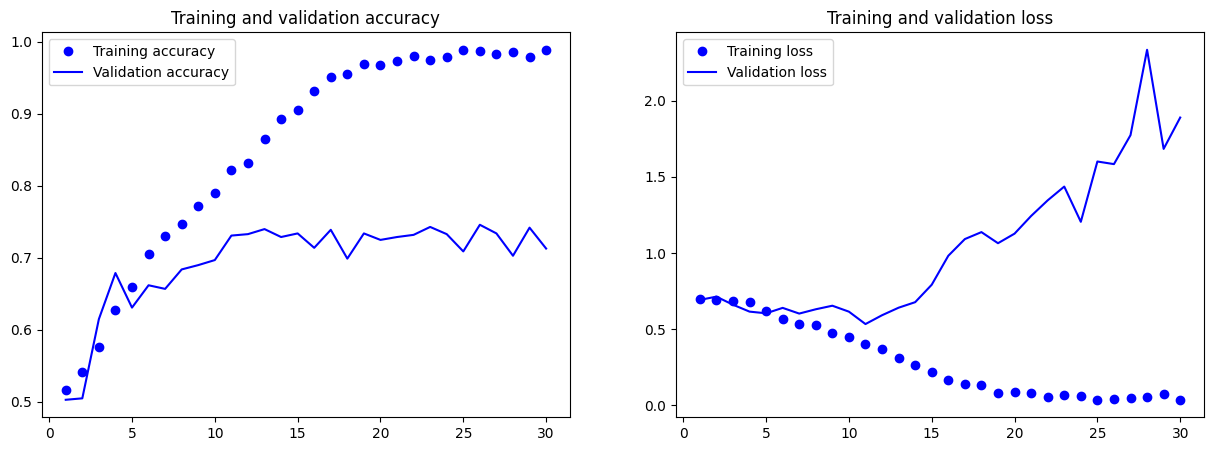

In [27]:
check_train_val_plot(history)

## 테스트 모델에서 모델 평가

In [28]:
test_model = keras.models.load_model("convetn_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 3s 41ms/step - loss: 0.5737 - accuracy: 0.7330
테스트 정확도: 0.733


## 데이터 증식 사용
- 참조 : https://albumentations.ai/
- 참조 : https://opencv.org/
- 참조 : https://scikit-image.org/


In [29]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

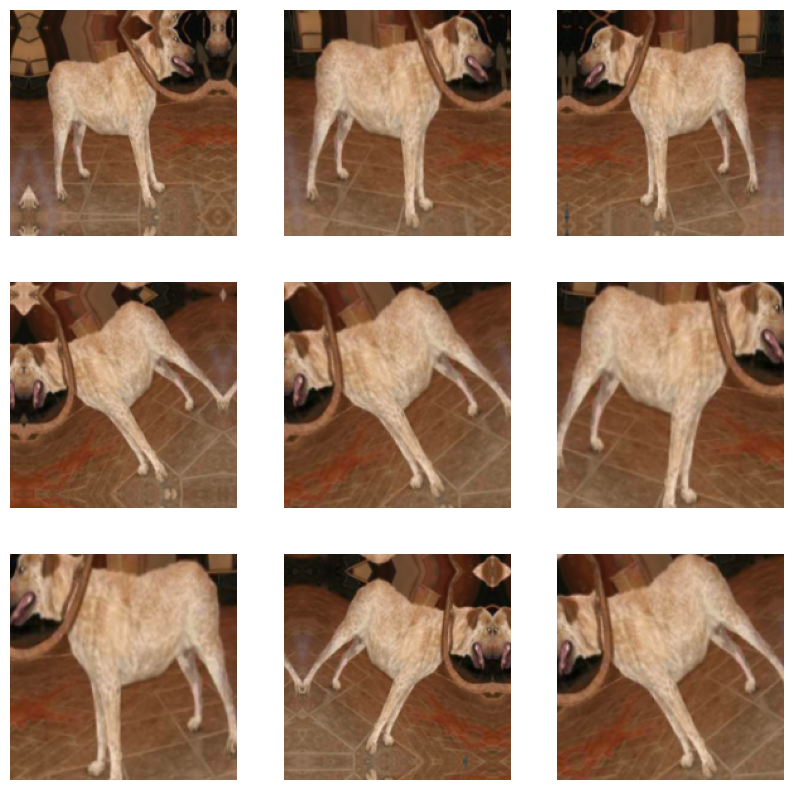

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [31]:
inputs = keras.Input(shape=(180, 180, 3)) # 입력층
x = data_augmentation(inputs) # 데이터 증식 단계 통과 시킴
x = layers.Rescaling(1./255)(x) # 이미지 [0, 1]

# 은닉층
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x) # 드롭아웃을 적용하면 과대적합이 덜 일어난다

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convent_from_scratch_with_augmentation.keras',
        save_best_only = True, # 1epoch vs 2epoch
        monitor = "val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/100
63/63 [==============================] - 10s 95ms/step - loss: 0.7108 - accuracy: 0.5280 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6967 - accuracy: 0.5285 - val_loss: 0.6922 - val_accuracy: 0.5050
Epoch 3/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6914 - accuracy: 0.5125 - val_loss: 0.6785 - val_accuracy: 0.5680
Epoch 4/100
63/63 [==============================] - 5s 76ms/step - loss: 0.6869 - accuracy: 0.5660 - val_loss: 0.6600 - val_accuracy: 0.6110
Epoch 5/100
63/63 [==============================] - 6s 94ms/step - loss: 0.6678 - accuracy: 0.6020 - val_loss: 0.7062 - val_accuracy: 0.5710
Epoch 6/100
63/63 [==============================] - 5s 79ms/step - loss: 0.6541 - accuracy: 0.6270 - val_loss: 0.6393 - val_accuracy: 0.6160
Epoch 7/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6333 - accuracy: 0.6440 - val_loss: 0.6010 - val_accuracy: 0.6540
Epoch

## 테스트 세트에서 모델 정확도 확인

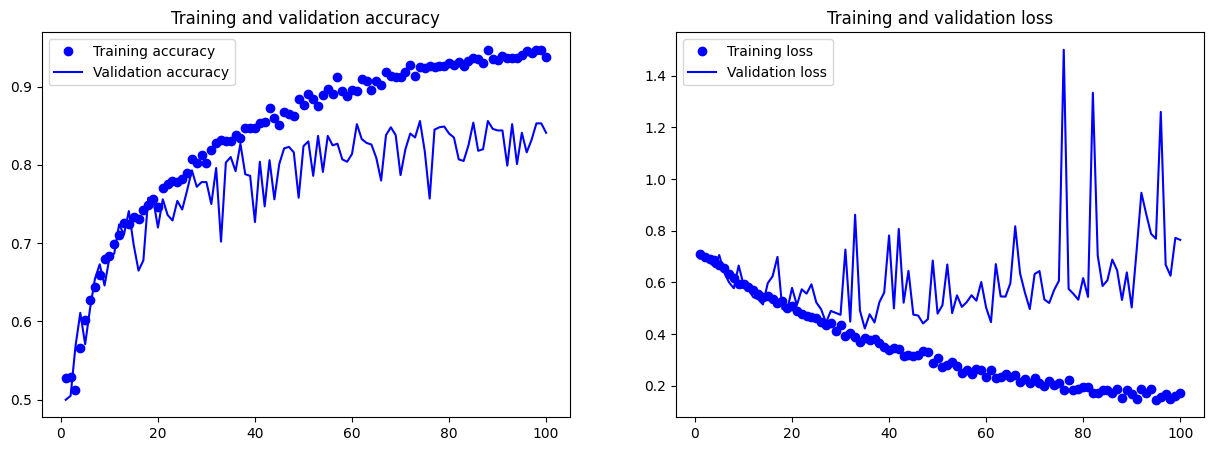

In [34]:
check_train_val_plot(history)

In [35]:
test_model = keras.models.load_model("convent_from_scratch_with_augmentation.keras") # 저장된 모델 불러오기
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 3s 40ms/step - loss: 0.4367 - accuracy: 0.8095
테스트 정확도: 0.809


## 사전 훈련된 모델
- 일반 정확도 : 73.3
- 데이터 증식 정확도 : 80.9
- 사전 훈련된 모델 : 97.5
- 모델 미세 조정하기 : 98.5
- 결론 : 딥러닝 프로젝트 시,
 + 주요 키워드 --> 사전 훈련된 모델 & 모델 미세 조정하기 chatgpt 샘플 코드 주세요!

## 머신러닝 프로젝트 vs 딥러닝 프로젝트
- 머신러닝 프로젝트의 핵심은 정확도 + 변수 추출 과정 설명 중요, 통계분석 중요
 + 데이터분석가 지망생들이 많이 함
- 딥러닝 프로젝트의 핵심은 정확도 + 어떤 모델 썼느냐! 모델에 대한 설명(영어 논문 또는 한글로 번역한 유튜브 공부)
 + 컴공 출신들이 많이 함

## 사전 훈련된 모델 활용
- pretrained model
- 참조 : https://paperswithcode.com/paper/very-deep-convolutional-networks-for-large
- 참조 : https://arxiv.org/abs/1905.11946v5